# Attribute prediction (gender) on PEMIU protected templates

Dataset: LFW (13.233 images)
Labels (M/F) from official source

1. InsightFace on synthesized face images from PEMIU enhanced templates
2. KNN on template
3. SVM on template

In [1]:
# System
import os

# Data preparation
import pandas as pd
import numpy as np

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pysankey import sankey

# Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8
# sns.set_style('whitegrid')

In [2]:
# Load evaluation of genders using InsightFace
df_pairs_gender = pd.read_csv("../evaluation/lfw_complete_genders.csv", sep=",")
df_pairs_gender.head()

,Unnamed: 0,lfw_image,lfw_embedding,lfw_image_pemiu,lfw_embedding_pemiu,lfw_filename_raw,gender_official,gender_insightface,gender_insightface_pemiu
0,0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...,../data/features_cleaner/Aaron_Eckhart_0001.npy,./sample_images_lfw_pemiu/Aaron_Eckhart_0001_p...,../data/features_cleaner_pemiu/Aaron_Eckhart_0...,Aaron_Eckhart_0001.png,M,M,F
1,1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...,../data/features_cleaner/Aaron_Guiel_0001.npy,./sample_images_lfw_pemiu/Aaron_Guiel_0001_pem...,../data/features_cleaner_pemiu/Aaron_Guiel_000...,Aaron_Guiel_0001.png,M,M,F
2,2,../data/lfw_align/Aaron_Patterson/Aaron_Patter...,../data/features_cleaner/Aaron_Patterson_0001.npy,./sample_images_lfw_pemiu/Aaron_Patterson_0001...,../data/features_cleaner_pemiu/Aaron_Patterson...,Aaron_Patterson_0001.png,M,M,F
3,3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...,../data/features_cleaner/Aaron_Peirsol_0001.npy,./sample_images_lfw_pemiu/Aaron_Peirsol_0001_p...,../data/features_cleaner_pemiu/Aaron_Peirsol_0...,Aaron_Peirsol_0001.png,M,M,M
4,4,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...,../data/features_cleaner/Aaron_Peirsol_0002.npy,./sample_images_lfw_pemiu/Aaron_Peirsol_0002_p...,../data/features_cleaner_pemiu/Aaron_Peirsol_0...,Aaron_Peirsol_0002.png,M,M,M


In [3]:
# Four samples are missing in the official gender list downloaded from the LFW website.
# They are assigned as 'x' and are omitted in the following evaluation
df_pairs_gender.loc[df_pairs_gender['gender_official'] == "X"]

,Unnamed: 0,lfw_image,lfw_embedding,lfw_image_pemiu,lfw_embedding_pemiu,lfw_filename_raw,gender_official,gender_insightface,gender_insightface_pemiu
10832,10832,../data/lfw_align/Robert_Evans/Robert_Evans_00...,../data/features_cleaner/Robert_Evans_0001.npy,./sample_images_lfw_pemiu/Robert_Evans_0001_pe...,../data/features_cleaner_pemiu/Robert_Evans_00...,Robert_Evans_0001.png,X,M,M
10833,10833,../data/lfw_align/Robert_Evans/Robert_Evans_00...,../data/features_cleaner/Robert_Evans_0002.npy,./sample_images_lfw_pemiu/Robert_Evans_0002_pe...,../data/features_cleaner_pemiu/Robert_Evans_00...,Robert_Evans_0002.png,X,F,F
11968,11968,../data/lfw_align/Tara_Kirk/Tara_Kirk_0001.png,../data/features_cleaner/Tara_Kirk_0001.npy,./sample_images_lfw_pemiu/Tara_Kirk_0001_pemiu...,../data/features_cleaner_pemiu/Tara_Kirk_0001.npy,Tara_Kirk_0001.png,X,F,F
13117,13117,../data/lfw_align/Yasser_Arafat/Yasser_Arafat_...,../data/features_cleaner/Yasser_Arafat_0005.npy,./sample_images_lfw_pemiu/Yasser_Arafat_0005_p...,../data/features_cleaner_pemiu/Yasser_Arafat_0...,Yasser_Arafat_0005.png,X,M,F


In [4]:
# Drop the gender 'X' samples
# df_pairs_gender.drop(df_pairs_gender.loc[df_pairs_gender['gender_official'] == "X"].index, inplace=True)

---

## Gender distribution of original LFW dataset

Visualize gender distribution of the original LFW dataset

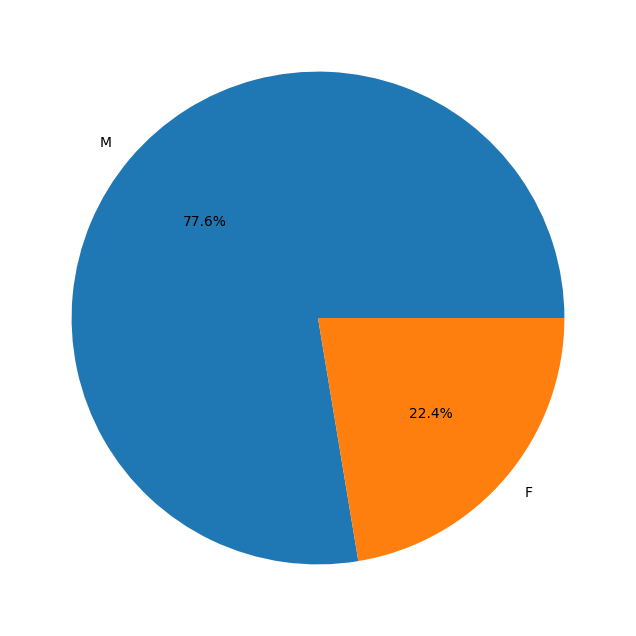

In [5]:
num_m = len(df_pairs_gender[df_pairs_gender["gender_official"]=="M"])
num_f = len(df_pairs_gender[df_pairs_gender["gender_official"]=="F"])
plt.pie([num_m, num_f], labels=['M', 'F'], autopct='%1.1f%%')
plt.show()

---

## Data preparation

For evaluation the LFW dataset is used, consisting of 13,233 samples. The original gender distribution of the LFW dataset is 77.6% male.

Data preparation
1. The official list of gender labels downloaded from the LFW website is missing four samples. Those four samples are dropped from the dataset.
2. The best sample for each identity is chosen using SER-FIQ Face Image Quality Assessment. We reduce the dataset to include only one sample per identity: 5,749 samples.
3. The dataset contains 1,471 female and 4,378 male identities. This gender unbalance negatively influences the training results. Therefore, we reduce the number of male identities to match the amount of female identities. This yields a dataset containing 2,942 identities.
4. We sort the dataset to alternate between one male and one female sample to make sure that in each k-fold, we always have a balanced set of samples in regard to gender.

---

## Attribute prediction using ML

ML algorithms:

- KNN
- SVM: Poly
- SVM: RBF
- SVM: Sigmoid

Dataset:
- LFW
- Balanced for gender equality: Around 3000 samples for male and female

Training:
- Model is trained using the corresponding embeddings, e.g.: For PEMIU blocksize 16, the training and testing is performed using embeddings of blocksize 16

Evaluation method:
- From embedding: Evaluation from unprotected and privacy enhanced (PEMIU) embeddings
- From image: Evaluation on embeddings created from reconstrcuted images produced from unprotected and privacy enhanced (PEMIU) embeddings

---

## Attribute prediction using ML and k-fold cross validation

Evaluation of the different machine learning algorithms.

Workflow:
- Introduce k-fold cross validation with 10 folds
- Calculate arithmetic mean as final result
- Source data is sorted alternately between male and female samples to improve neutral distribution over the k-folds
- Only one sample per identity: The first sample in the dataset is chosen
- Include standard deviation ("_std")

In [66]:
df_from_img = pd.read_csv('../evaluation/attribute_prediction_ml_with_cross_validation/attribute_from_img.csv', index_col=[0])
df_from_embedding = pd.read_csv('../evaluation/attribute_prediction_ml_with_cross_validation/attribute_from_embedding.csv', index_col=[0])

In [67]:
# From embedding
df_from_embedding.loc[0, ['blocksize']] = 'Unprotected'
df_from_embedding

,blocksize,knn_mean,knn_std,svm_poly_mean,svm_poly_std,svm_rbf_mean,svm_rbf_std,svm_sigmoid_mean,svm_sigmoid_std
0,Unprotected,0.7009,0.0359,0.7386,0.0173,0.8658,0.0277,0.6832,0.0315
1,16,0.5007,0.0047,0.5000,0.0008,0.5571,0.0266,0.5119,0.0343
2,32,0.4990,0.0048,0.5003,0.0013,0.5782,0.0224,0.5520,0.0205
3,64,0.5041,0.0046,0.5010,0.0023,0.6010,0.0332,0.5592,0.0242
4,128,0.5204,0.0097,0.5228,0.0092,0.6387,0.0227,0.5772,0.0195


In [8]:
# From image
df_from_img.loc[0, ['blocksize']] = 'Unprotected'
df_from_img

,blocksize,knn_mean,knn_std,svm_poly_mean,svm_poly_std,svm_rbf_mean,svm_rbf_std,svm_sigmoid_mean,svm_sigmoid_std
0,Unprotected,0.6958,0.0203,0.8096,0.0151,0.8922,0.0133,0.8549,0.0167
1,16,0.5085,0.0331,0.5048,0.0267,0.5017,0.0265,0.4922,0.0190
2,32,0.5129,0.0177,0.5030,0.0257,0.5034,0.0172,0.4980,0.0145
3,64,0.5061,0.0216,0.5156,0.0238,0.5333,0.0346,0.5167,0.0342
4,128,0.5279,0.0322,0.5496,0.0178,0.5738,0.0238,0.5642,0.0141


--- 

## Attack scenario: Predict gender of PEMIU protected embeddings

- Train model on unprotected embeddings (and images reconstructed from unprotected embeddings)
- Test model on PEMIU protected embeddings
- For each identity, only the sample with the highest image quality (SER_FIQ) is used for prediction

In [9]:
df_from_img = pd.read_csv('../evaluation/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/attribute_from_img.csv', index_col=[0])
df_from_embedding = pd.read_csv('../evaluation/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/attribute_from_embedding.csv', index_col=[0])

In [10]:
# From embedding
df_from_embedding

,blocksize,knn,svm_poly,svm_rbf,svm_sigmoid
0,16,0.499320,0.500000,0.540449,0.505438
1,32,0.502719,0.500000,0.556424,0.516655
2,64,0.506458,0.504079,0.589735,0.546567
3,128,0.547247,0.587695,0.649218,0.566961


In [11]:
# From image
df_from_img

,blocksize,knn,svm_poly,svm_rbf,svm_sigmoid
0,16,0.507138,0.503739,0.510537,0.514956
1,32,0.498980,0.506118,0.518015,0.520054
2,64,0.511557,0.545207,0.541808,0.545547
3,128,0.562203,0.599592,0.598912,0.585656


--- 

### Attack: Predict gender of PEMIU protected embeddings, but only on samples, where the synthesized image passes the FMR100 threshold

Workflow:
- Balance the dataset to include same amount of male and female samples
- Train model on unprotected templates and official gender labels
- Filter the dataset to only include the samples that pass the FMR100 threshold (meaning: where the cosine similarity is greater than 0.34)
- Predict labels only on filtered dataset

In [12]:
df_from_img = pd.read_csv('../evaluation/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold100/attribute_from_img.csv', index_col=[0])
df_from_embedding = pd.read_csv('../evaluation/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold100/attribute_from_embedding.csv', index_col=[0])
df_predicted_labels = pd.read_csv('../evaluation/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold100/predicted_labels.csv', index_col=[0])

In [13]:
# From embedding
# df_from_embedding

In [14]:
# From image
df_from_img

,blocksize,knn,svm_poly,svm_rbf,svm_sigmoid
0,16,0.693527,0.693527,0.671070,0.651255
1,32,0.659401,0.641689,0.619891,0.607629
2,64,0.662338,0.659091,0.619481,0.604545
3,128,0.732957,0.736723,0.702448,0.684369


In [15]:
# print('\n'.join(df_predicted_labels.columns))

In [16]:
# Count the number of samples that weren't predicted

counter = 0
mask_predicted = df_predicted_labels.columns.str.contains('pred_*')
for index in range(len(df_predicted_labels)):
    label_list = []
    for column in df_predicted_labels.loc[:, mask_predicted]:    
        label_list.append(df_predicted_labels[column][index])
    if pd.isnull(label_list).all():
        counter = counter + 1
print(f'Length of dataset: {len(df_predicted_labels)}')
print(f'Number of samples that weren\'t predicted: {counter}')

Length of dataset: 5748
Number of samples that weren't predicted: 1813


In [17]:
# len(df_predicted_labels) - sum(pd.isnull(df_predicted_labels['pred_fromimg_16_knn']))
# df_results_correct_prediction.index.tolist()[0]
# df_predicted_labels[df_results_correct_prediction.iloc[0][0]]

In [18]:
# Number of samples that were correctly predicted by ML algorithm and blocksize
df_results_correct_prediction = pd.DataFrame()
results = []
for column in df_predicted_labels.loc[:, mask_predicted]:
    correct_predictions = 0
    for index in range(len(df_predicted_labels)):
        if df_predicted_labels['gender_official'][index] == df_predicted_labels[column][index]:
            correct_predictions = correct_predictions + 1
    results.append(correct_predictions)
    # df_results_correct_prediction[column] = correct_predictions

df_results_correct_prediction = pd.DataFrame(results).T
df_results_correct_prediction.columns = df_predicted_labels.loc[:, mask_predicted].columns.tolist()
df_results_correct_prediction = df_results_correct_prediction.T
df_results_correct_prediction.rename(columns={0: 'Successful predictions'}, inplace=True)

# We want to calculate the percentage between the corrently classified labels and the total amount of 
# samples that were evaluated
total = []
for x in range(len(df_results_correct_prediction.index)):
    sum_of_no_predictions = sum(pd.isnull(df_predicted_labels[df_results_correct_prediction.index.tolist()[x]]))
    sum_of_predictions = len(df_predicted_labels) - sum_of_no_predictions
    total.append(sum_of_predictions)

df_results_correct_prediction['Possible predictions'] = total

# Reset index for sns barplot to work
df_results_correct_prediction.index.name = 'Model'
df_results_correct_prediction.reset_index(inplace=True)
df_results_correct_prediction

,Model,Successful predictions,Possible predictions
0,pred_fromimg_16_knn,525,757
1,pred_fromimg_32_knn,484,734
2,pred_fromimg_64_knn,1020,1540
3,pred_fromimg_128_knn,1946,2655
4,pred_fromimg_16_svm_poly,525,757
5,pred_fromimg_32_svm_poly,471,734
6,pred_fromimg_64_svm_poly,1015,1540
7,pred_fromimg_128_svm_poly,1956,2655
8,pred_fromimg_16_svm_rbf,508,757
9,pred_fromimg_32_svm_rbf,455,734


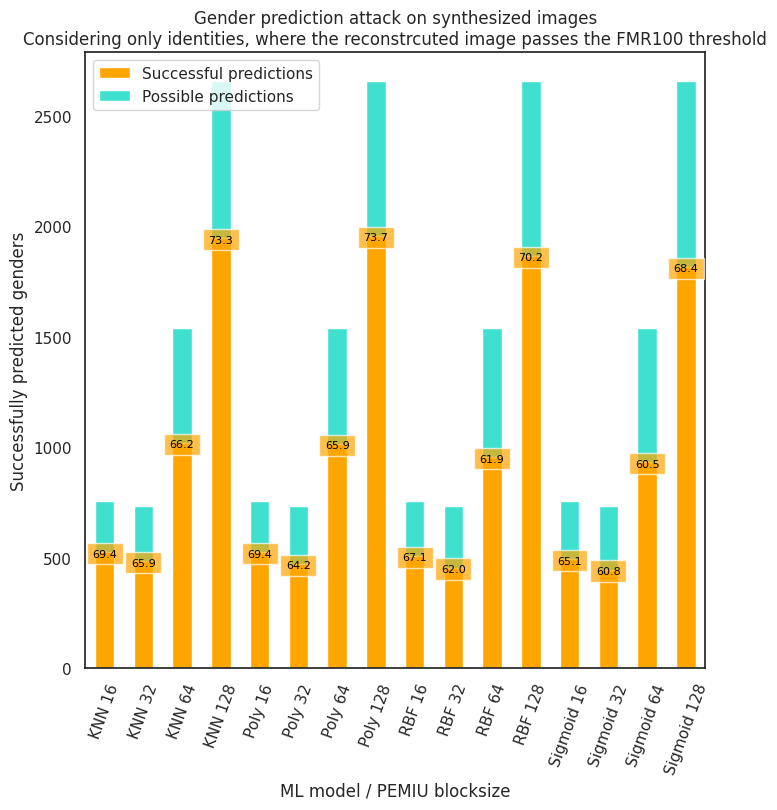

In [19]:
# Successfully predicted samples

# set seaborn plotting aesthetics
sns.set(style='white')
labels = ['KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128']

#create stacked bar chart
fig, ax = plt.subplots()
df_results_correct_prediction.iloc[0:16,0:2].set_index('Model').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_results_correct_prediction.iloc[0:16,[0,2]].set_index('Model').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Successfully predicted genders')
ax.set_title("Gender prediction attack on synthesized images\nConsidering only identities, where the reconstrcuted image passes the FMR100 threshold")

for index, p in enumerate(ax.patches):
    # percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    if index < 16:
        percentage = round(df_results_correct_prediction['Successful predictions'][index] / df_results_correct_prediction['Possible predictions'][index] * 100, 1)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}', (x-0.25, y-20), ha='center', fontweight='normal', fontsize=8, c='black', bbox=dict(facecolor='orange', alpha=0.7))
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)
        
plt.show()

---

## Attack: Predict gender of PEMIU protected embeddings, but only on samples, where the synthesized image passes the FMR1000 threshold

- Threshold now FMR1000: 0.4

In [20]:
df_from_img = pd.read_csv('../evaluation/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold1000/attribute_from_img.csv', index_col=[0])
df_predicted_labels = pd.read_csv('../evaluation/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold1000/predicted_labels.csv', index_col=[0])

In [21]:
df_from_img

,blocksize,knn,svm_poly,svm_rbf,svm_sigmoid
0,16,0.705882,0.764706,0.776471,0.764706
1,32,0.706294,0.776224,0.762238,0.734266
2,64,0.646320,0.698384,0.682226,0.664273
3,128,0.760632,0.781288,0.744836,0.733293


In [22]:
mask_predicted = df_predicted_labels.columns.str.contains('pred_*')

# Number of samples that were correctly predicted by ML algorithm and blocksize
df_results_correct_prediction = pd.DataFrame()
results = []
for column in df_predicted_labels.loc[:, mask_predicted]:
    correct_predictions = 0
    for index in range(len(df_predicted_labels)):
        if df_predicted_labels['gender_official'][index] == df_predicted_labels[column][index]:
            correct_predictions = correct_predictions + 1
    results.append(correct_predictions)
    # df_results_correct_prediction[column] = correct_predictions

df_results_correct_prediction = pd.DataFrame(results).T
df_results_correct_prediction.columns = df_predicted_labels.loc[:, mask_predicted].columns.tolist()
df_results_correct_prediction = df_results_correct_prediction.T
df_results_correct_prediction.rename(columns={0: 'Successful predictions'}, inplace=True)

# We want to calculate the percentage between the corrently classified labels and the total amount of 
# samples that were evaluated
total = []
for x in range(len(df_results_correct_prediction.index)):
    sum_of_no_predictions = sum(pd.isnull(df_predicted_labels[df_results_correct_prediction.index.tolist()[x]]))
    sum_of_predictions = len(df_predicted_labels) - sum_of_no_predictions
    total.append(sum_of_predictions)

df_results_correct_prediction['Possible predictions'] = total

# Reset index for sns barplot to work
df_results_correct_prediction.index.name = 'Model'
df_results_correct_prediction.reset_index(inplace=True)
df_results_correct_prediction

,Model,Successful predictions,Possible predictions
0,pred_fromimg_16_knn,60,85
1,pred_fromimg_32_knn,101,143
2,pred_fromimg_64_knn,360,557
3,pred_fromimg_128_knn,1252,1646
4,pred_fromimg_16_svm_poly,65,85
5,pred_fromimg_32_svm_poly,111,143
6,pred_fromimg_64_svm_poly,389,557
7,pred_fromimg_128_svm_poly,1286,1646
8,pred_fromimg_16_svm_rbf,66,85
9,pred_fromimg_32_svm_rbf,109,143


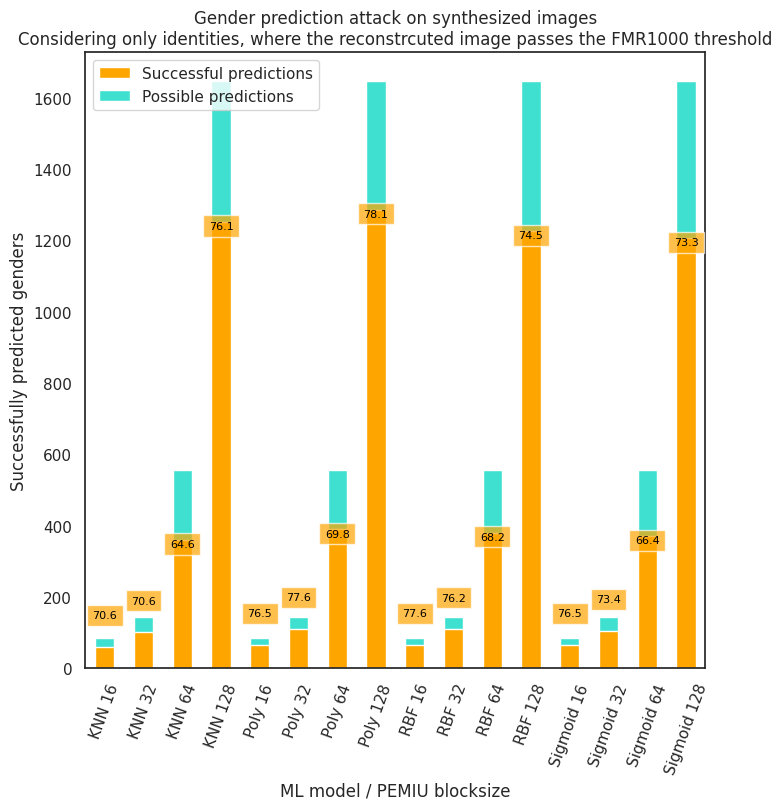

In [23]:
# Successfully predicted samples

# set seaborn plotting aesthetics
sns.set(style='white')
labels = ['KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128']

#create stacked bar chart
fig, ax = plt.subplots()
df_results_correct_prediction.iloc[0:16,0:2].set_index('Model').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_results_correct_prediction.iloc[0:16,[0,2]].set_index('Model').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Successfully predicted genders')
ax.set_title("Gender prediction attack on synthesized images\nConsidering only identities, where the reconstrcuted image passes the FMR1000 threshold")

for index, p in enumerate(ax.patches):
    # percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    if index < 16:
        percentage = round(df_results_correct_prediction['Successful predictions'][index] / df_results_correct_prediction['Possible predictions'][index] * 100, 1)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)
        # Form an offset to place the label above columns when columns are very small
        offset = 0
        if y < 115:
            offset = +80
        else:
            offset = -20
        ax.annotate(f'{percentage}', (x-0.25, y+offset), ha='center', fontweight='normal', fontsize=8, c='black', bbox=dict(facecolor='orange', alpha=0.7))

# ax.axhline(df_genders['gender_official'].value_counts().tolist()[0])
    
plt.show()

## Visual inspection of reconstrcuted images that pass FMR1000_TH

Filenames of identities where reconstrcuted image from PEMIU enhanced template pass FMR1000_TH

In [24]:
filenames_pass_th1000_df = pd.DataFrame(df_predicted_labels[df_predicted_labels['cos_sim_bonafide_synthesized_pemiu16_normalized'] > 0.40])
filenames_pass_th1000 = []
for i in range(len(df_predicted_labels)):
    if df_predicted_labels.iloc[i]['gender_official'] == df_predicted_labels.iloc[i]['pred_fromimg_16_svm_poly']:
        filenames_pass_th1000.append(df_predicted_labels.iloc[i]['filename'])

In [25]:
# Sort by highest cos_sim
filenames_pass_th1000_df.sort_values(by="cos_sim_bonafide_synthesized_pemiu16_normalized", axis=0, ascending=False, inplace=True)
filenames_pass_th1000_df.head()

,filename,img_original_quality,pemiu16_fromimg,pemiu32_fromimg,pemiu64_fromimg,pemiu128_fromimg,pemiu0_fromimg,pemiu16,pemiu32,pemiu64,...,pred_fromembedding_64_svm_poly,pred_fromembedding_128_svm_poly,pred_fromembedding_16_svm_rbf,pred_fromembedding_32_svm_rbf,pred_fromembedding_64_svm_rbf,pred_fromembedding_128_svm_rbf,pred_fromembedding_16_svm_sigmoid,pred_fromembedding_32_svm_sigmoid,pred_fromembedding_64_svm_sigmoid,pred_fromembedding_128_svm_sigmoid
224,Amer_al-Saadi_0001,0.762527,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Amer_al-Saadi...,../data/features_cleaner_pemiu32/Amer_al-Saadi...,../data/features_cleaner_pemiu64/Amer_al-Saadi...,...,M,NaN,M,NaN,F,NaN,M,NaN,F,NaN
4232,Pat_DAmuro_0001,0.885008,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Pat_DAmuro_00...,../data/features_cleaner_pemiu32/Pat_DAmuro_00...,../data/features_cleaner_pemiu64/Pat_DAmuro_00...,...,NaN,M,M,NaN,NaN,M,M,NaN,NaN,M
5085,Stefano_Gabbana_0001,0.814571,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Stefano_Gabba...,../data/features_cleaner_pemiu32/Stefano_Gabba...,../data/features_cleaner_pemiu64/Stefano_Gabba...,...,NaN,M,M,NaN,NaN,M,M,NaN,NaN,F
5115,Stephen_Joseph_0001,0.829871,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Stephen_Josep...,../data/features_cleaner_pemiu32/Stephen_Josep...,../data/features_cleaner_pemiu64/Stephen_Josep...,...,NaN,NaN,F,NaN,NaN,NaN,F,NaN,NaN,NaN
3075,Kevin_Spacey_0002,0.843273,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Kevin_Spacey_...,../data/features_cleaner_pemiu32/Kevin_Spacey_...,../data/features_cleaner_pemiu64/Kevin_Spacey_...,...,NaN,NaN,M,M,NaN,NaN,M,F,NaN,NaN


In [26]:
print(' '.join(filenames_pass_th1000))

Alfred_Sant_0001 Ali_Abbas_0002 Alvaro_Uribe_0017 Alyse_Beaupre_0001 Amer_al-Saadi_0001 Andrew_Sabey_0001 Andy_Griggs_0001 Ari_Bousbib_0001 Barry_Diller_0001 Benito_Santiago_0001 David_Nalbandian_0013 Djabir_Said-Guerni_0001 Flor_Montulo_0001 Francisco_Santos_0001 Garry_Trudeau_0002 Gary_Condit_0001 Gary_Locke_0001 Gordon_Campbell_0001 Guillermo_Coria_0005 Henk_Bekedam_0001 Hugo_Chavez_0004 Intisar_Ajouri_0002 Iva_Majoli_0002 Jamie_Olis_0001 Jennifer_Capriati_0023 Jenny_Romero_0001 John_Moe_0001 Jose_Alencar_0001 Juan_Carlos_Ferrero_0022 Juan_Pablo_Montoya_0004 Kevin_Spacey_0002 Kirk_Ferentz_0002 Leland_Chapman_0001 Lemuel_Montulo_0001 Lleyton_Hewitt_0018 Mahendra_Chaudhry_0001 Marina_Hands_0001 Mike_Montgomery_0001 Mike_Scioscia_0002 Mike_Weir_0008 Norah_Jones_0006 Padraig_Harrington_0001 Pat_DAmuro_0001 Paula_Zahn_0001 Paul_Greengrass_0001 Pierre_Gagnon_0001 Randy_Johnson_0001 Razali_Ismail_0001 Robert_Altman_0001 Robert_DeFraites_0002 Robert_Hanssen_0001 Salma_Hayek_0004 Sim_Yong_00

In [27]:
df_predicted_labels.columns

Index(['filename', 'img_original_quality', 'pemiu16_fromimg',
       'pemiu32_fromimg', 'pemiu64_fromimg', 'pemiu128_fromimg',
       'pemiu0_fromimg', 'pemiu16', 'pemiu32', 'pemiu64', 'pemiu128', 'pemiu0',
       'gender_official', 'cos_sim_bonafide_synthesized_pemiu16_normalized',
       'cos_sim_bonafide_synthesized_pemiu32_normalized',
       'cos_sim_bonafide_synthesized_pemiu64_normalized',
       'cos_sim_bonafide_synthesized_pemiu128_normalized',
       'cos_sim_bonafide_synthesized_unprotected_normalized',
       'pred_fromimg_16_knn', 'pred_fromimg_32_knn', 'pred_fromimg_64_knn',
       'pred_fromimg_128_knn', 'pred_fromimg_16_svm_poly',
       'pred_fromimg_32_svm_poly', 'pred_fromimg_64_svm_poly',
       'pred_fromimg_128_svm_poly', 'pred_fromimg_16_svm_rbf',
       'pred_fromimg_32_svm_rbf', 'pred_fromimg_64_svm_rbf',
       'pred_fromimg_128_svm_rbf', 'pred_fromimg_16_svm_sigmoid',
       'pred_fromimg_32_svm_sigmoid', 'pred_fromimg_64_svm_sigmoid',
       'pred_fromimg_1

In [28]:
# Cos_sim of single file
df_predicted_labels[df_predicted_labels['filename'] == 'Alfred_Sant_0001']['cos_sim_bonafide_synthesized_pemiu16_normalized'].tolist()[0]

0.4047885884549104

In [29]:
# Img filepath
df_predicted_labels[df_predicted_labels['filename'] == 'Alfred_Sant_0001']['filename'].tolist()[0]

'Alfred_Sant_0001'

In [30]:
df_predicted_labels[df_predicted_labels['filename'] == f'Alfred_Sant_0001'][f'pred_fromimg_16_svm_poly'].tolist()[0]

'M'

In [31]:
def get_original_image(filename):
    return f"../data/lfw_align/{'_'.join(filename.split('_')[:-1])}/{filename}.png"

def get_reconstructed_image(filename):
    path = f"../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/sample_images_unprotected"
    return f"{path}/{filename}_reconstructed.png"

def get_pemiu_image(filename, blocksize):
    path = f"../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/sample_images_pemiu{blocksize}"
    return f"{path}/{filename}_pemiu{blocksize}.png"

def get_cos_sim(filename, blocksize=False):
    if blocksize:
        return format(round(df_predicted_labels[df_predicted_labels['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_pemiu{blocksize}_normalized'].tolist()[0], 2), '.2f')
    else:
        return format(round(df_predicted_labels[df_predicted_labels['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_unprotected_normalized'].tolist()[0], 2), '.2f')

def get_gender_prediction(filename, blocksize):
    return df_predicted_labels[df_predicted_labels['filename'] == f'{filename}'][f'pred_fromimg_{blocksize}_svm_poly'].tolist()[0]

def get_gender(filename):
    return df_predicted_labels[df_predicted_labels['filename'] == f'{filename}'][f'gender_official'].tolist()[0]
    
def display_image(filename, display_title=False):
    # display images
    fig, ax = plt.subplots(1,3)
    
    if display_title:
        ax[0].set_title(f"Real", pad=10)
        ax[1].set_title("Reconstructed", pad=10)
        ax[2].set_title("Pemiu 16", pad=10)
        # ax[3].set_title("Pemiu Reconstr.", pad=16)
    
    gender_color_prediction ='skyblue' if get_gender_prediction(filename, '16') == 'M' else 'lightpink'
    gender_color ='skyblue' if get_gender(filename) == 'M' else 'lightpink'
    
    # Display cosine similarity score
    ax[0].text(4, 152, f"{filename}", fontsize=8, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[0].text(140, 150, get_gender(filename), fontsize=14, c=gender_color, bbox=dict(facecolor='black', alpha=0.5))
    ax[1].text(82, 105, get_cos_sim(filename), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(82, 105, get_cos_sim(filename, '16'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(3,105, get_gender_prediction(filename, '16'), fontsize=14, c=gender_color_prediction, bbox=dict(facecolor='black', alpha=0.5))
    
    ax[0].imshow(mpimg.imread(get_original_image(filename)))
    ax[1].imshow(mpimg.imread(get_reconstructed_image(filename)))
    ax[2].imshow(mpimg.imread(get_pemiu_image(filename, "16")))
    # ax[3].imshow(mpimg.imread(get_pemiu_image(filename, "32")))
     
    for x in range(0, 3):
        ax[x].axis('off')

In [32]:
def display_image_pemiu(filename, display_title=False):
    # display images
    fig, ax = plt.subplots(1,3)
    
    titles = ["Pemiu 32", "Pemiu 64", "Pemiu 128"]
    if display_title:
        for idx, title in enumerate(titles):
            ax[idx].set_title(title, pad=10)
    
    gender_color_prediction ='skyblue' if get_gender_prediction(filename, '16') == 'M' else 'lightpink'
    gender_color ='skyblue' if get_gender(filename) == 'M' else 'lightpink'
    # ax[0].text(4, 152, f"{filename}", fontsize=8, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    
    # Cos sim display
    ax[0].text(82, 105, get_cos_sim(filename, '32'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[1].text(82, 105, get_cos_sim(filename, '64'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(82, 105, get_cos_sim(filename, '128'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    
    # Gender prediction
    ax[0].text(3,105, get_gender_prediction(filename, '32'), fontsize=14, c=gender_color_prediction, bbox=dict(facecolor='black', alpha=0.5))
    ax[1].text(3,105, get_gender_prediction(filename, '64'), fontsize=14, c=gender_color_prediction, bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(3,105, get_gender_prediction(filename, '128'), fontsize=14, c=gender_color_prediction, bbox=dict(facecolor='black', alpha=0.5))
    
    ax[0].imshow(mpimg.imread(get_pemiu_image(filename, "32")))
    ax[1].imshow(mpimg.imread(get_pemiu_image(filename, "64")))
    ax[2].imshow(mpimg.imread(get_pemiu_image(filename, "128")))
     
    for x in range(0, 3):
        ax[x].axis('off')

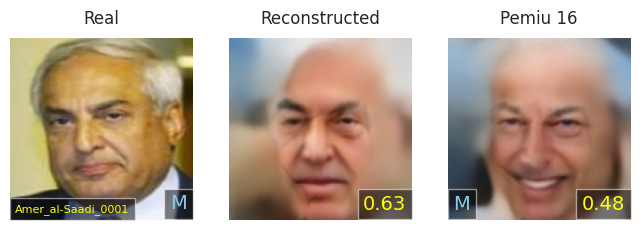

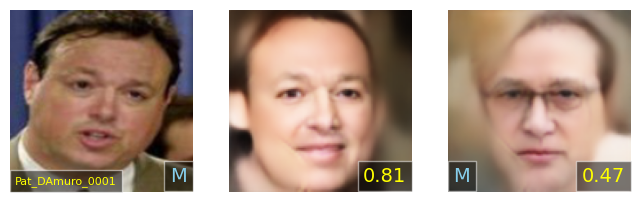

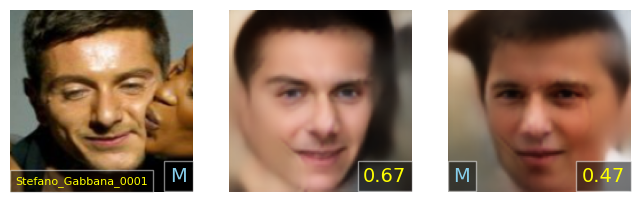

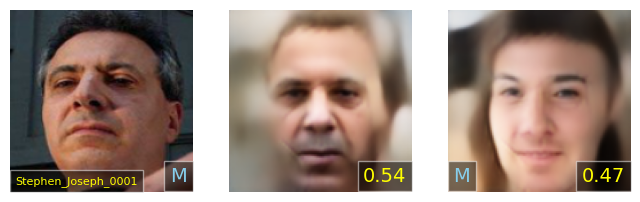

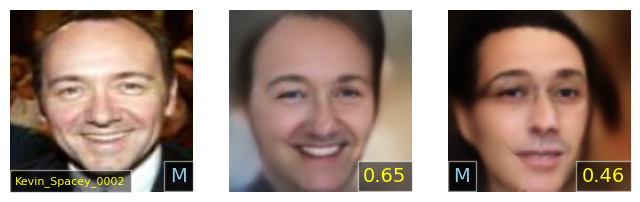

In [33]:
# Highest cos_sim for male subjects
for index, name in enumerate(filenames_pass_th1000_df['filename']):
    if index == 0:
        display_image(name, display_title=True)
    elif index < 5:
        display_image(name)

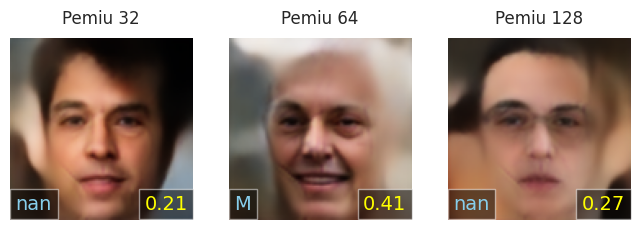

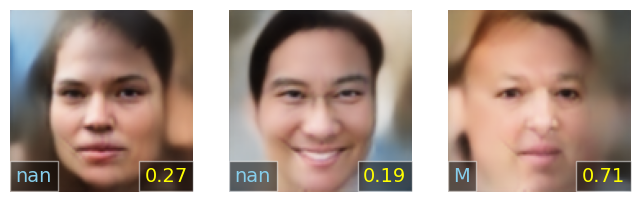

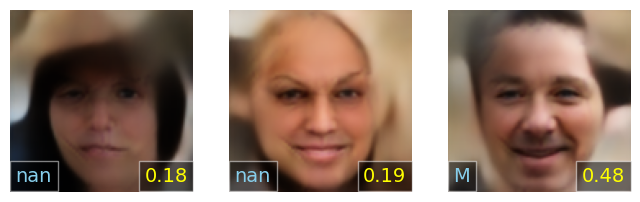

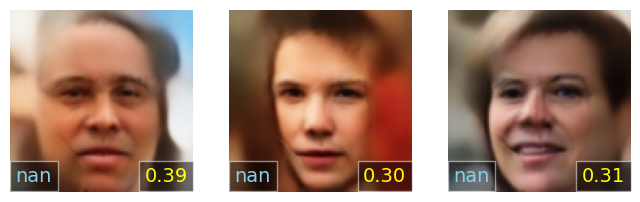

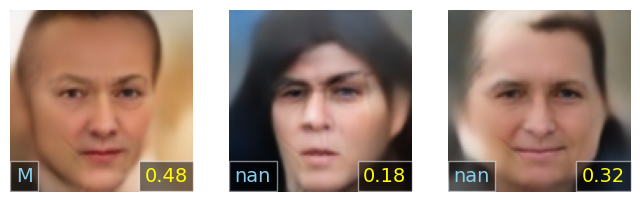

In [34]:
# Highest cos_sim for male subjects cont.
for index, name in enumerate(filenames_pass_th1000_df['filename']):
    if index == 0:
        display_image_pemiu(name, display_title=True)
    elif index < 5:
        display_image_pemiu(name)

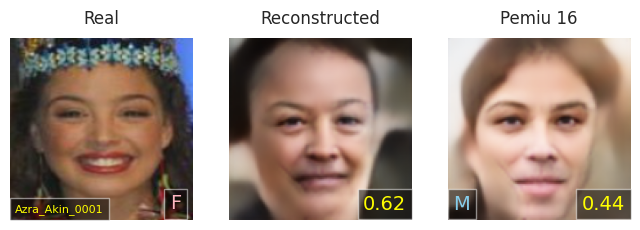

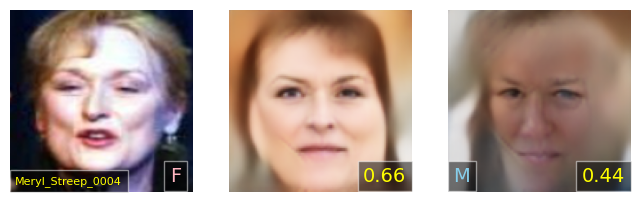

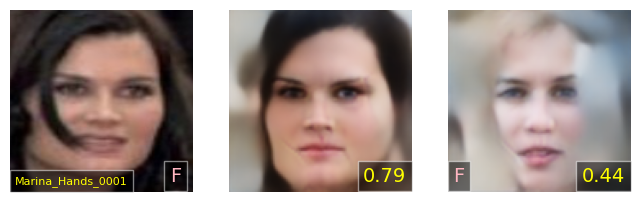

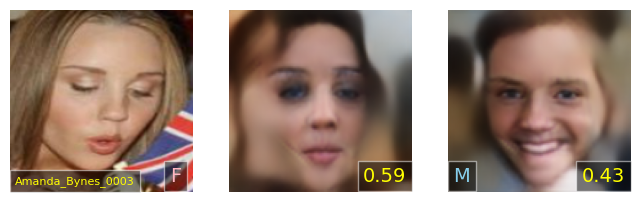

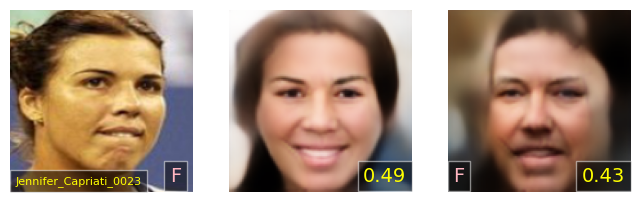

In [35]:
# Highest cos_sim for female subjects
for index, name in enumerate(filenames_pass_th1000_df[filenames_pass_th1000_df['gender_official'] == 'F']['filename']):
    if index == 0:
        display_image(name, True)
    elif index < 5:
        display_image(name)

In [36]:
filenames_pass_th1000_df[filenames_pass_th1000_df['gender_official'] != filenames_pass_th1000_df['pred_fromimg_16_svm_poly']]
# filenames_pass_th1000_df

,filename,img_original_quality,pemiu16_fromimg,pemiu32_fromimg,pemiu64_fromimg,pemiu128_fromimg,pemiu0_fromimg,pemiu16,pemiu32,pemiu64,...,pred_fromembedding_64_svm_poly,pred_fromembedding_128_svm_poly,pred_fromembedding_16_svm_rbf,pred_fromembedding_32_svm_rbf,pred_fromembedding_64_svm_rbf,pred_fromembedding_128_svm_rbf,pred_fromembedding_16_svm_sigmoid,pred_fromembedding_32_svm_sigmoid,pred_fromembedding_64_svm_sigmoid,pred_fromembedding_128_svm_sigmoid
370,Ariel_Sharon_0045,0.733378,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Ariel_Sharon_...,../data/features_cleaner_pemiu32/Ariel_Sharon_...,../data/features_cleaner_pemiu64/Ariel_Sharon_...,...,NaN,M,M,NaN,NaN,M,M,NaN,NaN,M
431,Azra_Akin_0001,0.723928,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Azra_Akin_000...,../data/features_cleaner_pemiu32/Azra_Akin_000...,../data/features_cleaner_pemiu64/Azra_Akin_000...,...,NaN,NaN,F,NaN,NaN,NaN,F,NaN,NaN,NaN
3728,Meryl_Streep_0004,0.693415,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Meryl_Streep_...,../data/features_cleaner_pemiu32/Meryl_Streep_...,../data/features_cleaner_pemiu64/Meryl_Streep_...,...,NaN,M,M,NaN,NaN,F,M,NaN,NaN,M
215,Amanda_Bynes_0003,0.675164,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Amanda_Bynes_...,../data/features_cleaner_pemiu32/Amanda_Bynes_...,../data/features_cleaner_pemiu64/Amanda_Bynes_...,...,NaN,M,F,NaN,NaN,M,M,NaN,NaN,M
335,Ann_Veneman_0008,0.705408,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Ann_Veneman_0...,../data/features_cleaner_pemiu32/Ann_Veneman_0...,../data/features_cleaner_pemiu64/Ann_Veneman_0...,...,M,NaN,M,NaN,F,NaN,M,NaN,F,NaN
1716,Floyd_Keith_0001,0.759715,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Floyd_Keith_0...,../data/features_cleaner_pemiu32/Floyd_Keith_0...,../data/features_cleaner_pemiu64/Floyd_Keith_0...,...,M,M,M,NaN,F,M,M,NaN,F,M
1605,Eric_Lloyd_0001,0.641877,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Eric_Lloyd_00...,../data/features_cleaner_pemiu32/Eric_Lloyd_00...,../data/features_cleaner_pemiu64/Eric_Lloyd_00...,...,NaN,NaN,M,F,NaN,NaN,M,F,NaN,NaN
4960,Serena_Williams_0033,0.689352,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,..

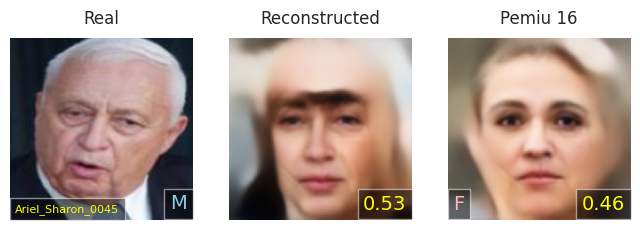

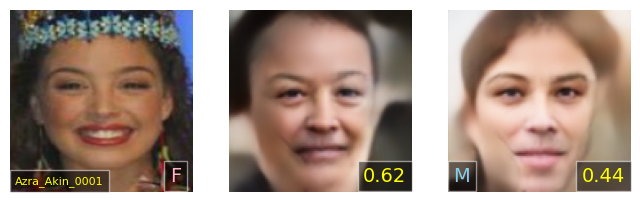

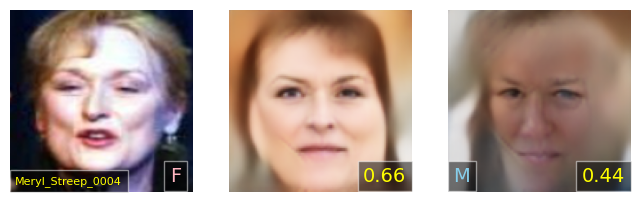

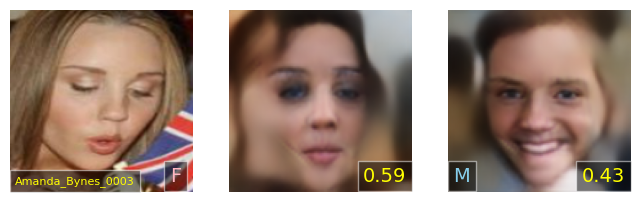

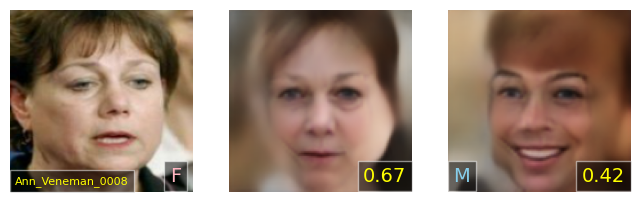

In [37]:
# Images where predicted gender doesn't match the official one
for index, name in enumerate(filenames_pass_th1000_df[filenames_pass_th1000_df['gender_official'] != filenames_pass_th1000_df['pred_fromimg_16_svm_poly']]['filename']):
    if index == 0:
        display_image(name, True)
    elif index < 5:
        display_image(name)

---

## Analysis of gender distribution for unprotected and PEMIU protected templates

In [38]:
df_genders = pd.read_csv('../evaluation/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/predicted_labels.csv', index_col=[0])
df_genders.head()

,filename,img_original_quality,pemiu16_fromimg,pemiu32_fromimg,pemiu64_fromimg,pemiu128_fromimg,pemiu0_fromimg,pemiu16,pemiu32,pemiu64,...,pred_fromembedding_64_svm_poly,pred_fromembedding_128_svm_poly,pred_fromembedding_16_svm_rbf,pred_fromembedding_32_svm_rbf,pred_fromembedding_64_svm_rbf,pred_fromembedding_128_svm_rbf,pred_fromembedding_16_svm_sigmoid,pred_fromembedding_32_svm_sigmoid,pred_fromembedding_64_svm_sigmoid,pred_fromembedding_128_svm_sigmoid
0,Aaron_Eckhart_0001,0.785188,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Aaron_Eckhart...,../data/features_cleaner_pemiu32/Aaron_Eckhart...,../data/features_cleaner_pemiu64/Aaron_Eckhart...,...,M,M,M,M,M,M,M,M,M,F
77,Adelina_Avila_0001,0.846964,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Adelina_Avila...,../data/features_cleaner_pemiu32/Adelina_Avila...,../data/features_cleaner_pemiu64/Adelina_Avila...,...,M,M,F,M,M,M,F,M,M,M
1,Aaron_Guiel_0001,0.764814,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Aaron_Guiel_0...,../data/features_cleaner_pemiu32/Aaron_Guiel_0...,../data/features_cleaner_pemiu64/Aaron_Guiel_0...,...,M,M,F,F,M,F,F,F,M,F
88,Adriana_Lima_0001,0.736330,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Adriana_Lima_...,../data/features_cleaner_pemiu32/Adriana_Lima_...,../data/features_cleaner_pemiu64/Adriana_Lima_...,...,M,M,F,F,F,F,F,F,F,F
2,Aaron_Patterson_0001,0.737193,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,experiments/experiment_7_model1_pemiu_block_si...,../data/features_cleaner_pemiu16/Aaron_Patters...,../data/features_cleaner_pemiu32/Aaron_Patters...,../data/features_cleaner_pemiu64/Aaron_Patters...,...,M,M,M,F,F,M,M,F,F,M


In [39]:
# print('\n'.join(df_genders.columns))

In [40]:
# Get a mask for columns starting with 'pred_fromimg_' / 'pred_fromembedding_'
mask_fromimg = df_genders.columns.str.contains('pred_fromimg_*')
mask_fromembedding = df_genders.columns.str.contains('pred_fromembedding_*')

# Count male and female samples per evaluation column
gender_count_fromimg = {}
gender_count_fromimg['genders_official'] = df_genders['gender_official'].value_counts().tolist()
for column in df_genders.loc[:, mask_fromimg]:
    gender_count_fromimg[column] = df_genders[column].value_counts().tolist()
# gender_count_fromimg

In [41]:
gender_count_fromembedding = {}
gender_count_fromembedding['genders_official'] = df_genders['gender_official'].value_counts().tolist()
for column in df_genders.loc[:, mask_fromembedding]:
    gender_count_fromembedding[column] = df_genders[column].value_counts().tolist()
# gender_count_fromembedding

In [42]:
df_gender_count_fromimg = pd.DataFrame.from_dict(gender_count_fromimg, orient='columns')
df_gender_count_fromimg = df_gender_count_fromimg.rename(index={0: 'M', 1: 'F'}).T
df_gender_count_fromimg

,M,F
genders_official,1471,1471
pred_fromimg_16_knn,2355,587
pred_fromimg_32_knn,2427,515
pred_fromimg_64_knn,2420,522
pred_fromimg_128_knn,2399,543
pred_fromimg_16_svm_poly,2047,895
pred_fromimg_32_svm_poly,2126,816
pred_fromimg_64_svm_poly,2095,847
pred_fromimg_128_svm_poly,2119,823
pred_fromimg_16_svm_rbf,1657,1285


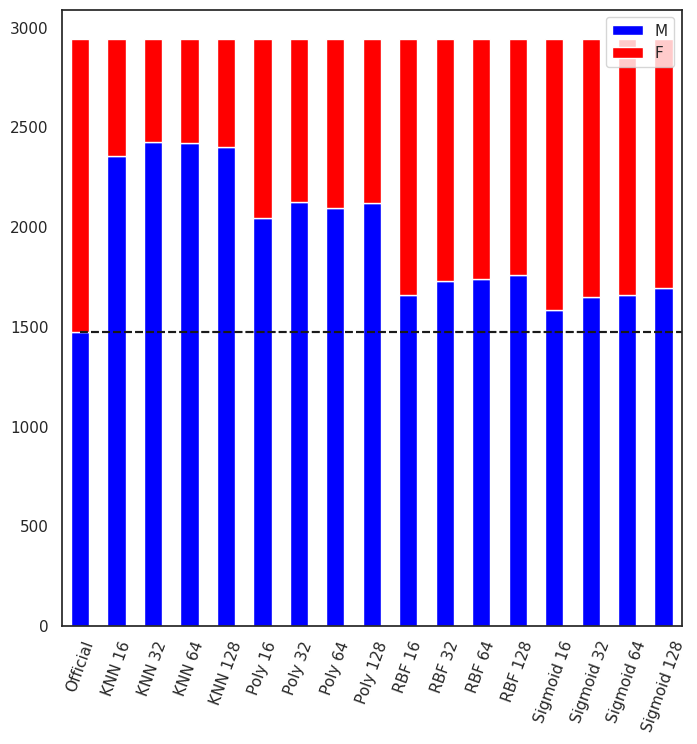

In [43]:
# create stacked bar chart for students DataFrame
df_gender_count_fromimg.plot(kind='bar', stacked=True, color=['blue', 'red'])
 
# Add Title and Labels
# plt.title('Intermediate Students Pass %')
# plt.xlabel('Year')
# plt.ylabel('Percentage Ranges')
labels = ['Official',
        'KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128',]
plt.xticks(range(0,len(df_gender_count_fromimg.index)), labels, rotation=70)

# horizontal line indicating the threshold
threshold = df_genders['gender_official'].value_counts().tolist()
plt.plot([0, 20], [threshold, threshold], "k--")

plt.show()

In [44]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [45]:
df_gender_count_fromimg.index.name = 'Model'
df_gender_count_fromimg.reset_index(inplace=True)
# df_gender_count_fromimg.rename(columns={'ID': 'Model'}, inplace=True)
df_gender_count_fromimg

,Model,M,F
0,genders_official,1471,1471
1,pred_fromimg_16_knn,2355,587
2,pred_fromimg_32_knn,2427,515
3,pred_fromimg_64_knn,2420,522
4,pred_fromimg_128_knn,2399,543
5,pred_fromimg_16_svm_poly,2047,895
6,pred_fromimg_32_svm_poly,2126,816
7,pred_fromimg_64_svm_poly,2095,847
8,pred_fromimg_128_svm_poly,2119,823
9,pred_fromimg_16_svm_rbf,1657,1285


In [46]:
df_gender_count_fromimg.iloc[2][1] + df_gender_count_fromimg.iloc[2][2]

2942

### Distribution of predicted genders using different ML algorithms

- Dataset: genders distributed 50/50
- Only best quality sample per identity

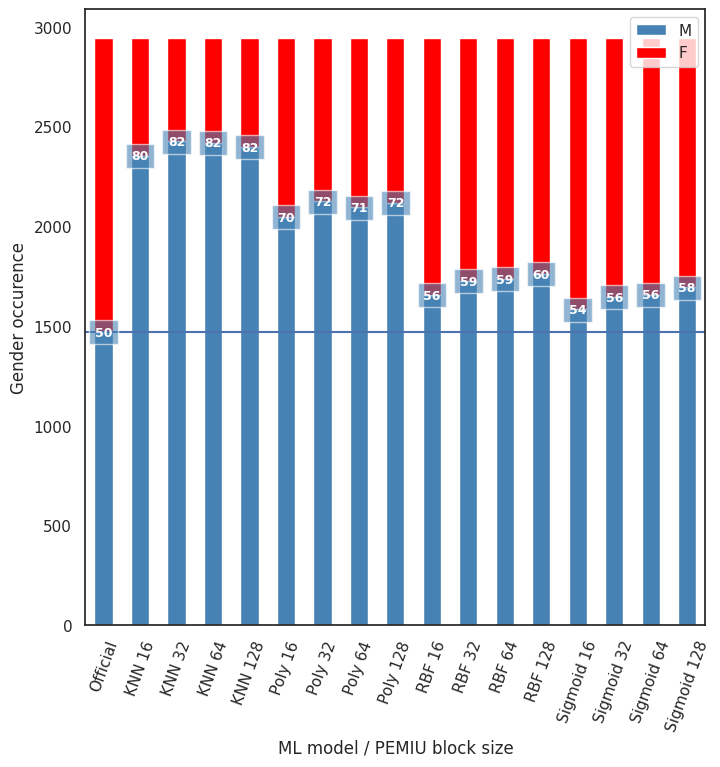

In [47]:
#set seaborn plotting aesthetics
sns.set(style='white')

#use red for bars with value less than 10 and green for all other bars
#cols = ['red' if df_gender_count_fromimg[''] < 10 else 'green' for x in df_gender_count_fromimg]
# cols = ['red' for x in df_gender_count_fromimg.columns if x.endswith('knn')]

#create stacked bar chart
ax = df_gender_count_fromimg.set_index('Model').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU block size', ylabel='Gender occurence')

ax.axhline(df_genders['gender_official'].value_counts().tolist()[0])

for index, p in enumerate(ax.patches):
    # percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    if index < 17:
        percent_male = df_gender_count_fromimg['M'][index]
        percent_total = df_gender_count_fromimg.iloc[1][1] + df_gender_count_fromimg.iloc[1][2]
        percentage = format(round(percent_male / percent_total * 100, 0), '.0f')
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}', (x-0.25, y-20), ha='center', fontweight='bold', fontsize=9, c='white', bbox=dict(facecolor='steelblue', alpha=0.6))

# Color names: https://matplotlib.org/stable/gallery/color/named_colors.html
#for i, bar in enumerate(ax.patches):
    #for j in [0, 4, 8, 12, 17, 21, 25, 29]:
        #if i in [1 + j, 2 + j, 3 + j, 4 + j] and (j == 0 or j == 8):
            #bar.set_color('deepskyblue')
        #if i in [1 + j, 2 + j, 3 + j, 4 + j] and (j == 4 or j == 12):
            #bar.set_color('cornflowerblue')
        #if i in [1 + j, 2 + j, 3 + j, 4 + j] and (j == 17 or j == 25):
            #bar.set_color('indianred')
        #if i in [1 + j, 2 + j, 3 + j, 4 + j] and (j == 21 or j == 29):
            #bar.set_color('darkred')
    
plt.show()

---

## Gender prediction using InsightFace model

In [48]:
lfw_complete_genders = pd.read_csv("../evaluation/lfw_complete_genders.csv", sep=",")
lfw_complete_genders.head()

,Unnamed: 0,lfw_image,lfw_embedding,lfw_image_pemiu,lfw_embedding_pemiu,lfw_filename_raw,gender_official,gender_insightface,gender_insightface_pemiu
0,0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...,../data/features_cleaner/Aaron_Eckhart_0001.npy,./sample_images_lfw_pemiu/Aaron_Eckhart_0001_p...,../data/features_cleaner_pemiu/Aaron_Eckhart_0...,Aaron_Eckhart_0001.png,M,M,F
1,1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...,../data/features_cleaner/Aaron_Guiel_0001.npy,./sample_images_lfw_pemiu/Aaron_Guiel_0001_pem...,../data/features_cleaner_pemiu/Aaron_Guiel_000...,Aaron_Guiel_0001.png,M,M,F
2,2,../data/lfw_align/Aaron_Patterson/Aaron_Patter...,../data/features_cleaner/Aaron_Patterson_0001.npy,./sample_images_lfw_pemiu/Aaron_Patterson_0001...,../data/features_cleaner_pemiu/Aaron_Patterson...,Aaron_Patterson_0001.png,M,M,F
3,3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...,../data/features_cleaner/Aaron_Peirsol_0001.npy,./sample_images_lfw_pemiu/Aaron_Peirsol_0001_p...,../data/features_cleaner_pemiu/Aaron_Peirsol_0...,Aaron_Peirsol_0001.png,M,M,M
4,4,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...,../data/features_cleaner/Aaron_Peirsol_0002.npy,./sample_images_lfw_pemiu/Aaron_Peirsol_0002_p...,../data/features_cleaner_pemiu/Aaron_Peirsol_0...,Aaron_Peirsol_0002.png,M,M,M


In [49]:
# Drop the gender 'X' samples
lfw_complete_genders.drop(lfw_complete_genders.loc[lfw_complete_genders['gender_official'] == "X"].index, inplace=True)

In [50]:
lfw_complete_off_vs_insightface = lfw_complete_genders.drop(columns=['lfw_embedding', 'lfw_image_pemiu', 
                                   'Unnamed: 0', 'lfw_image', 'lfw_embedding_pemiu',
                                  'lfw_filename_raw', 'gender_insightface_pemiu'])
lfw_complete_off_vs_pemiu16 = lfw_complete_genders.drop(columns=['lfw_embedding', 'lfw_image_pemiu', 
                                   'Unnamed: 0', 'lfw_image', 'lfw_embedding_pemiu',
                                  'lfw_filename_raw', 'gender_insightface'])

In [51]:
df_genders_insightface = lfw_complete_genders.drop(columns=['lfw_embedding', 'lfw_image_pemiu', 
                                   'Unnamed: 0', 'lfw_image', 'lfw_embedding_pemiu',
                                  'lfw_filename_raw'])

In [52]:
df_genders_insightface.head()

,gender_official,gender_insightface,gender_insightface_pemiu
0,M,M,F
1,M,M,F
2,M,M,F
3,M,M,M
4,M,M,M


In [53]:
lfw_complete_off_vs_insightface.head()

,gender_official,gender_insightface
0,M,M
1,M,M
2,M,M
3,M,M
4,M,M


In [54]:
lfw_complete_off_vs_pemiu16.head()

,gender_official,gender_insightface_pemiu
0,M,F
1,M,F
2,M,F
3,M,M
4,M,M


In [55]:
lfw_complete_off_vs_insightface.value_counts()

gender_official  gender_insightface
M                M                     10050
F                F                      2699
                 M                       262
M                F                       218
dtype: int64

In [56]:
gender_official = lfw_complete_off_vs_insightface['gender_official'].value_counts()[0:2]
gender_official

M    10268
F     2961
Name: gender_official, dtype: int64

In [57]:
gender_insightface = lfw_complete_off_vs_insightface['gender_insightface'].value_counts()[0:2]
gender_insightface

M    10312
F     2917
Name: gender_insightface, dtype: int64

In [58]:
lfw_complete_off_vs_insightface['gender_official'].value_counts()

M    10268
F     2961
Name: gender_official, dtype: int64

In [59]:
cm_genders_insightface = confusion_matrix(lfw_complete_off_vs_insightface['gender_official'],
                                          lfw_complete_off_vs_insightface['gender_insightface'])
cm_genders_insightface

array([[ 2699,   262],
       [  218, 10050]])

In [60]:
cm_genders_insightface

array([[ 2699,   262],
       [  218, 10050]])

### Confusion matrix for gender prediction using InsightFace

- Benchmark for InsightFace gender prediction algorithm
- Test on real LFW images and official labels

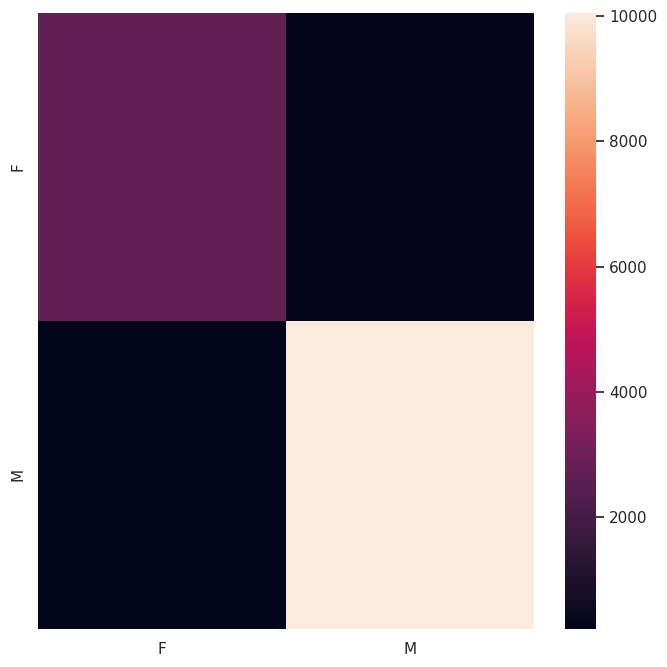

In [61]:
#set seaborn plotting aesthetics
sns.set(style='white')
cm = sns.heatmap(cm_genders_insightface, xticklabels=['F', 'M'], yticklabels=['F', 'M'])

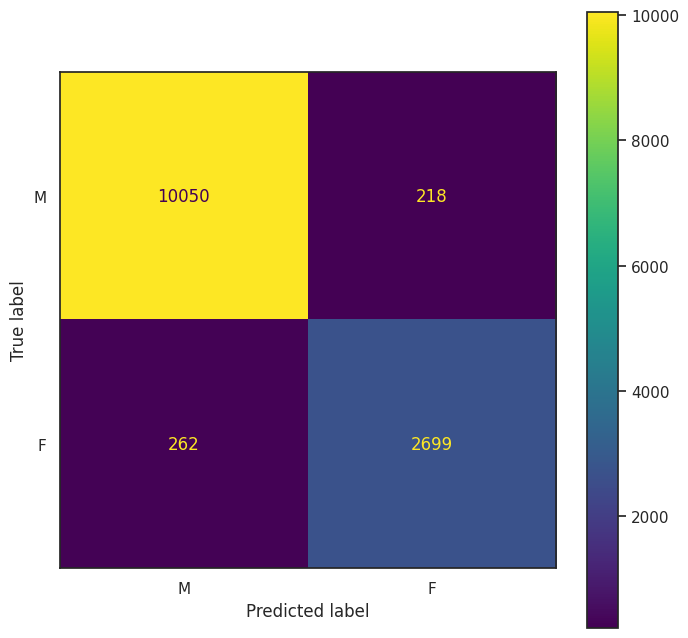

Insight face false prediction rate: 3.66 %


In [62]:
cm = confusion_matrix(df_pairs_gender['gender_official'], df_pairs_gender['gender_insightface'], labels=["M", "F"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["M", "F"])
disp.plot(values_format = '')
plt.show()

false_prediction_unmodified = []
for index, element in enumerate(df_pairs_gender['gender_official']):
    if not df_pairs_gender['gender_insightface'].iloc[index]:
        break
    if element != df_pairs_gender['gender_insightface'][index]:
        false_prediction_unmodified.append(element)
        
print(f"Insight face false prediction rate: {round((len(false_prediction_unmodified) / len(df_pairs_gender) * 100), 2)} %")

### Confusion matrix 

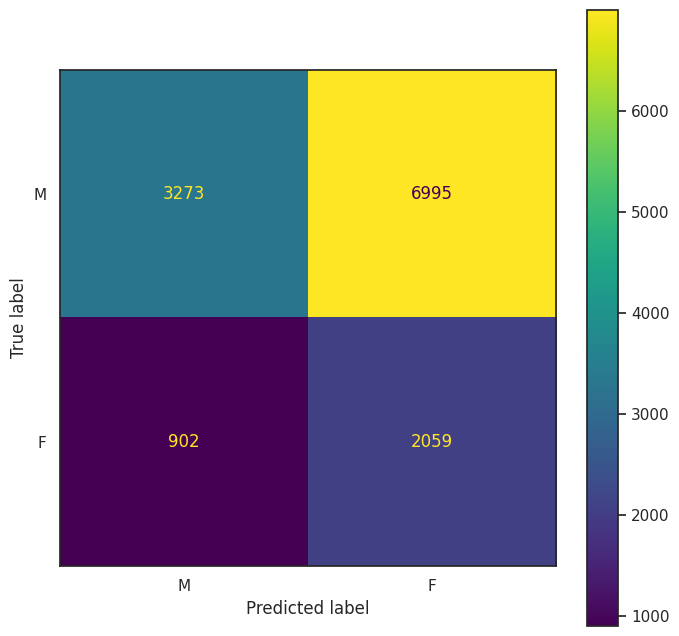

False prediction rate between LFW genuine gender and pemiu embedding image reconstruction: 59.71 %


In [63]:
cm = confusion_matrix(df_pairs_gender['gender_official'], df_pairs_gender['gender_insightface_pemiu'], labels=["M", "F"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["M", "F"])
disp.plot(values_format = '')
plt.show()

false_prediction_pemiu = []
for index, element in enumerate(df_pairs_gender['gender_official']):
    if not df_pairs_gender['gender_insightface_pemiu'].iloc[index]:
        break
    if element != df_pairs_gender['gender_insightface_pemiu'][index]:
        false_prediction_pemiu.append(element)
        
print(f"False prediction rate between LFW genuine gender and pemiu embedding image reconstruction: {round((len(false_prediction_pemiu) / len(df_pairs_gender) * 100), 2)} %")

### Sankey flow of InsightFace gender prediction

#### Official gender label vs. InsightFace predicted

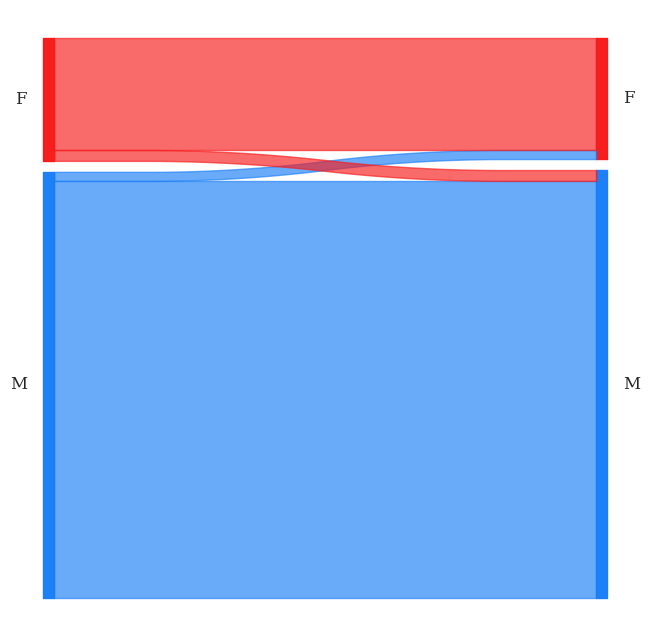

In [64]:
# Drop the gender 'X' samples
df_pairs_gender.drop(df_pairs_gender.loc[df_pairs_gender['gender_official'] == "X"].index, inplace=True)

colorDict = {
    'M':'#1b7ef7',
    'F':'#f71b1b',
}

ax = sankey(
    df_pairs_gender['gender_official'], df_pairs_gender['gender_insightface'], aspect=20, colorDict=colorDict,
    leftLabels=['M','F'],
    rightLabels=['M','F'],
    fontsize=12
)

#### Official gender label vs. InsightFace predicted on images generated from PEMIU enhanced templates

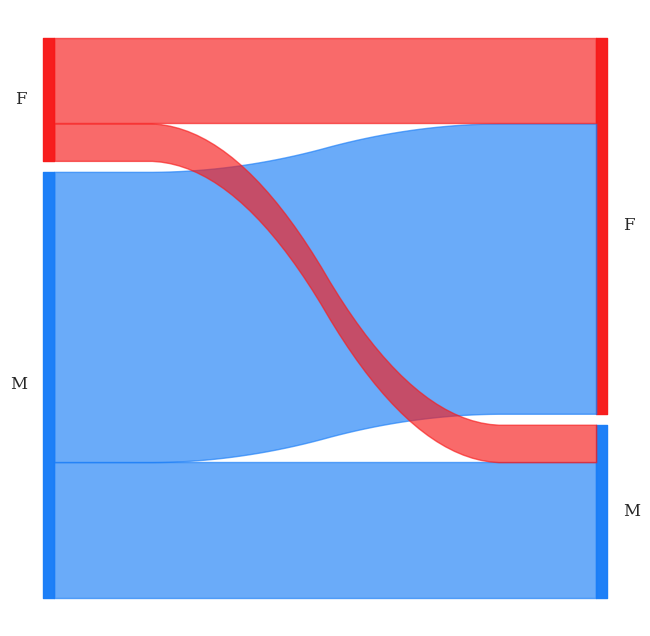

In [65]:
colorDict = {
    'M':'#1b7ef7',
    'F':'#f71b1b',
}

ax = sankey(
    df_pairs_gender['gender_official'], df_pairs_gender['gender_insightface_pemiu'], aspect=20, colorDict=colorDict,
    leftLabels=['M','F'],
    rightLabels=['M','F'],
    fontsize=12
)